## Data Generation for Flash Hit Time Detection Models
### First: multiple photons at the same time from a single point source

In [6]:
import sys
sys.path.append('..')
sys.path.append('../..')

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from tqdm import tqdm, trange
import os
import pickle
from waveforms.make_waveform import BatchedLightSimulation

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sim = BatchedLightSimulation(cfg="../../waveforms/templates/waveform_sim.yaml").to(device)

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001
	LIGHT_WINDOW: [1, 10]


torch.Size([1, 8000])


Text(0, 0.5, 'Photon Count')

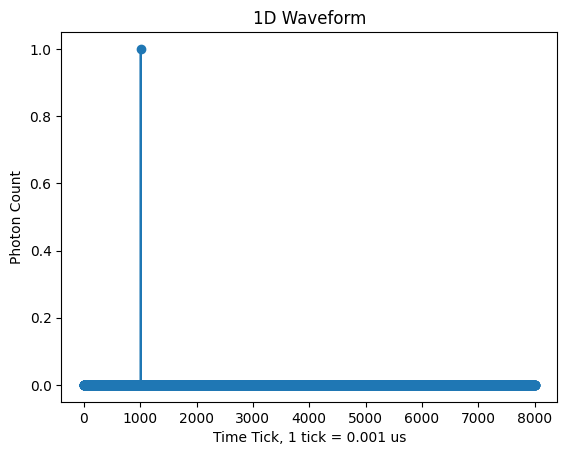

In [29]:
pmt_ids = torch.full((1,), 0) 
arrival_times = torch.zeros(1, dtype=torch.int64) + 1000
wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, n_pmts=1)
print(wf.shape)

ticks = np.arange(wf.shape[1])
plt.plot(ticks, wf.squeeze(0), marker='o')
plt.title("1D Waveform")
plt.xlabel(f"Time Tick, 1 tick = {sim.light_tick_size} us")
plt.ylabel("Photon Count")

In [30]:
# Simulating with SiPM electronics convolution
# def forward(self, timing_dist: torch.Tensor, scintillation=True, tpb_delay=True, combined=True, jax=False):
output, info = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=False)
output = output.detach().cpu().numpy()

Text(0, 0.5, 'ADC')

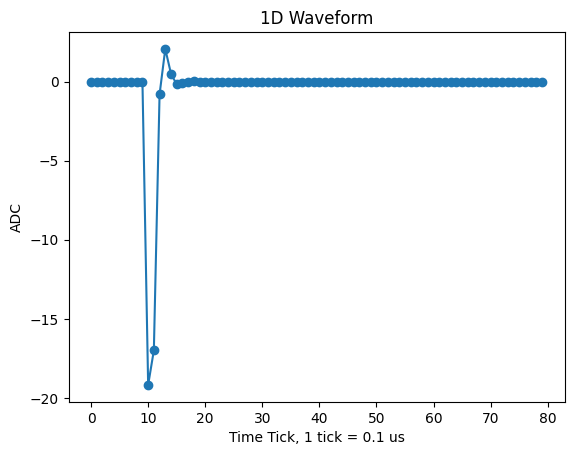

In [31]:
############### Plotting ############################
ticks = np.arange(output.shape[0])
plt.plot(ticks, output, marker='o')
plt.title("1D Waveform")
plt.xlabel(f"Time Tick, 1 tick = {sim.light_tick_size * sim.downsample_factor} us")
plt.ylabel("ADC")

### Sub-Bin Precision Study (ignore if noise in baseline)

In [7]:
timing_offsets = torch.linspace(499, 508, 11)  # 10 values from 500 to ~510
print(timing_offsets)

pmt_ids = torch.full((1,), 0)

peak_signals = []
peak_bins = []
arrival_signals = []
arrival_bins = []

threshold = -1e-5 # signal threshold

for i, val in enumerate(timing_offsets):
    # generate photon timing distribution
    arrival_times = torch.zeros(1, dtype=torch.int64) + int(val.item())
    print(arrival_times)
    wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, n_pmts=1)
    
    # convolve with detector response
    output, info = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=False)
    output = output.detach().cpu().numpy()  # shape [1000]
    
    # check arrival bin (first nonzero bin should be ~50 ns after offset)
    above_thresh = np.where(output < threshold)[0]
    if len(above_thresh) == 0:
        print(f"No signal detected for offset {val.item()}")
        continue
    
    arrival_bin = above_thresh[0]
    arrival_bins.append(arrival_bin)
    arrival_signals.append(output[arrival_bin])
    
    # get peak signal (largest value in the waveform)
    peak_bin = np.argmin(output)
    peak_signals.append(output[peak_bin])
    peak_bins.append(peak_bin)

print(peak_signals[0])

tensor([499.0000, 499.9000, 500.8000, 501.7000, 502.6000, 503.5000, 504.4000,
        505.3000, 506.2000, 507.1000, 508.0000])
tensor([499])
tensor([499])
tensor([500])
tensor([501])
tensor([502])
tensor([503])
tensor([504])
tensor([505])
tensor([506])
tensor([507])
tensor([508])
-0.3218692


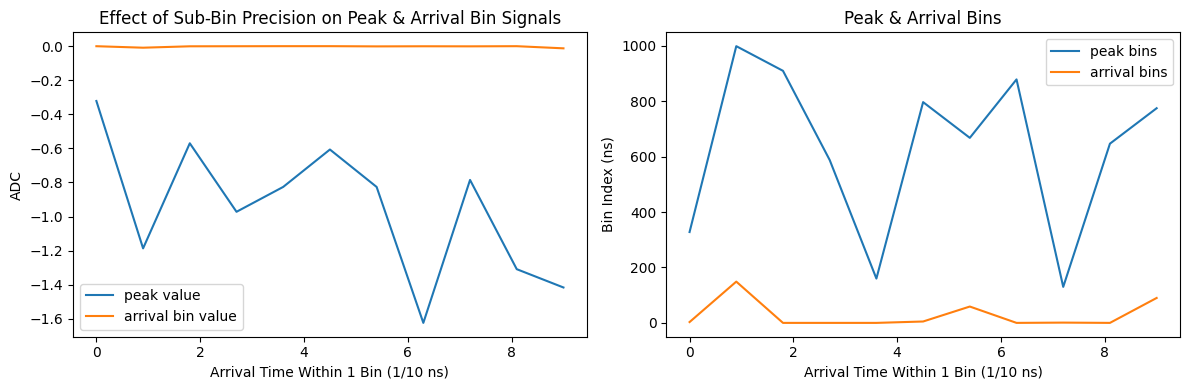

In [8]:
ticks = np.linspace(0, 9, 11)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# --- First plot: ADC values ---
axs[0].plot(ticks, peak_signals, label='peak value')
axs[0].plot(ticks, arrival_signals, label='arrival bin value')
axs[0].set_xlabel("Arrival Time Within 1 Bin (1/10 ns)")
axs[0].set_ylabel("ADC")
axs[0].set_title("Effect of Sub-Bin Precision on Peak & Arrival Bin Signals")
axs[0].legend()

# --- Second plot: Bin indices ---
axs[1].plot(ticks, peak_bins, label='peak bins')
axs[1].plot(ticks, arrival_bins, label='arrival bins')
axs[1].set_xlabel("Arrival Time Within 1 Bin (1/10 ns)")
axs[1].set_ylabel("Bin Index (ns)")
axs[1].set_title("Peak & Arrival Bins")
axs[1].legend()

plt.tight_layout()
plt.show()

### Actual Pipeline to Generate a Bunch of Waveforms

In [68]:
nphotons = np.random.randint(1, 1000, 1000)  # 100 random integers between 1 and 1000
arrival_times = np.random.uniform(0, 1, size=1000) * 7000  # 100 arrival times in [0, 1000) ns, scaled to ps if needed
offset = 1000

In [75]:
nphotons = np.random.randint(1, 1000, 1000)  # 100 random integers between 1 and 1000
all_arrival_times = np.random.uniform(0, 1, size=1000) * 7000  # in nanoseconds

sim_waveforms = []

for i, n in enumerate(nphotons):
    pmt_ids = torch.full((n,), 0, dtype=torch.int64)  # PMT 0 for all photons
    arrival_time = int(all_arrival_times[i])  # convert to int for torch.full
    arrival_times_tensor = torch.full((n,), arrival_time, dtype=torch.int64)

    wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times_tensor, n_pmts=1)
    output, info = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=False)
    output = output.detach().cpu().numpy()
    sim_waveforms.append(output)

data = {}
data['waveforms'] = sim_waveforms
data['arrival_times'] = (all_arrival_times / sim.downsample_factor)

np.save("test_flashes1.npy", data, allow_pickle=True)

Text(0.5, 1.0, 'Input 1D Waveforms and Hit Times')

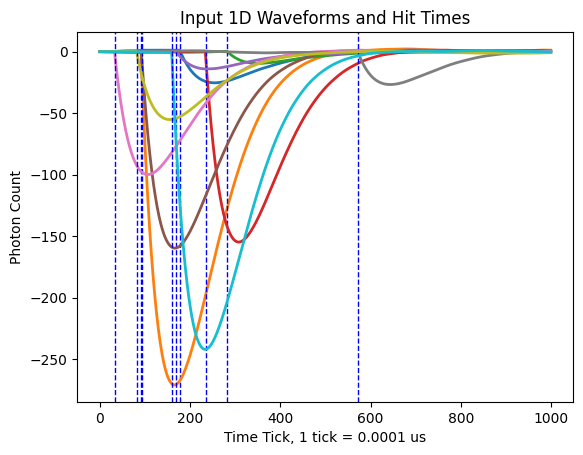

In [76]:
waveforms = np.load('test_flashes1.npy', allow_pickle=True).item()
ticks = np.arange(len(waveforms['waveforms'][0]))

for i, wf in enumerate(waveforms['waveforms'][0:10]):
    plt.plot(ticks, wf, linewidth=2)
    plt.axvline(x=waveforms['arrival_times'][i] + (offset / sim.downsample_factor**2), color='b', linestyle='--', linewidth=1, label='True arrival')

plt.xlabel(f"Time Tick, 1 tick = {sim.light_tick_size} us")
plt.ylabel("Photon Count")
plt.title(f"Input 1D Waveforms and Hit Times")

(1000,)


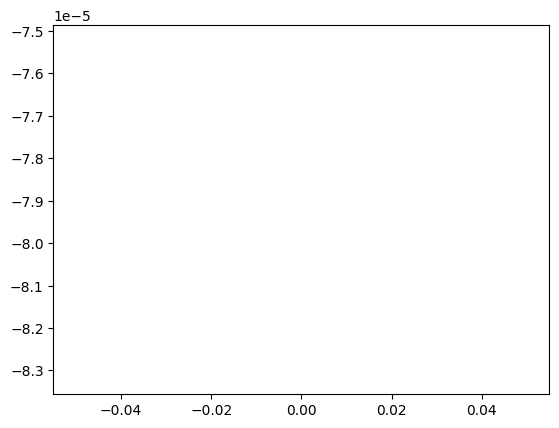

In [81]:

# plt.plot(np.arange(100), sim.downsample_waveform(waveforms['waveforms']))

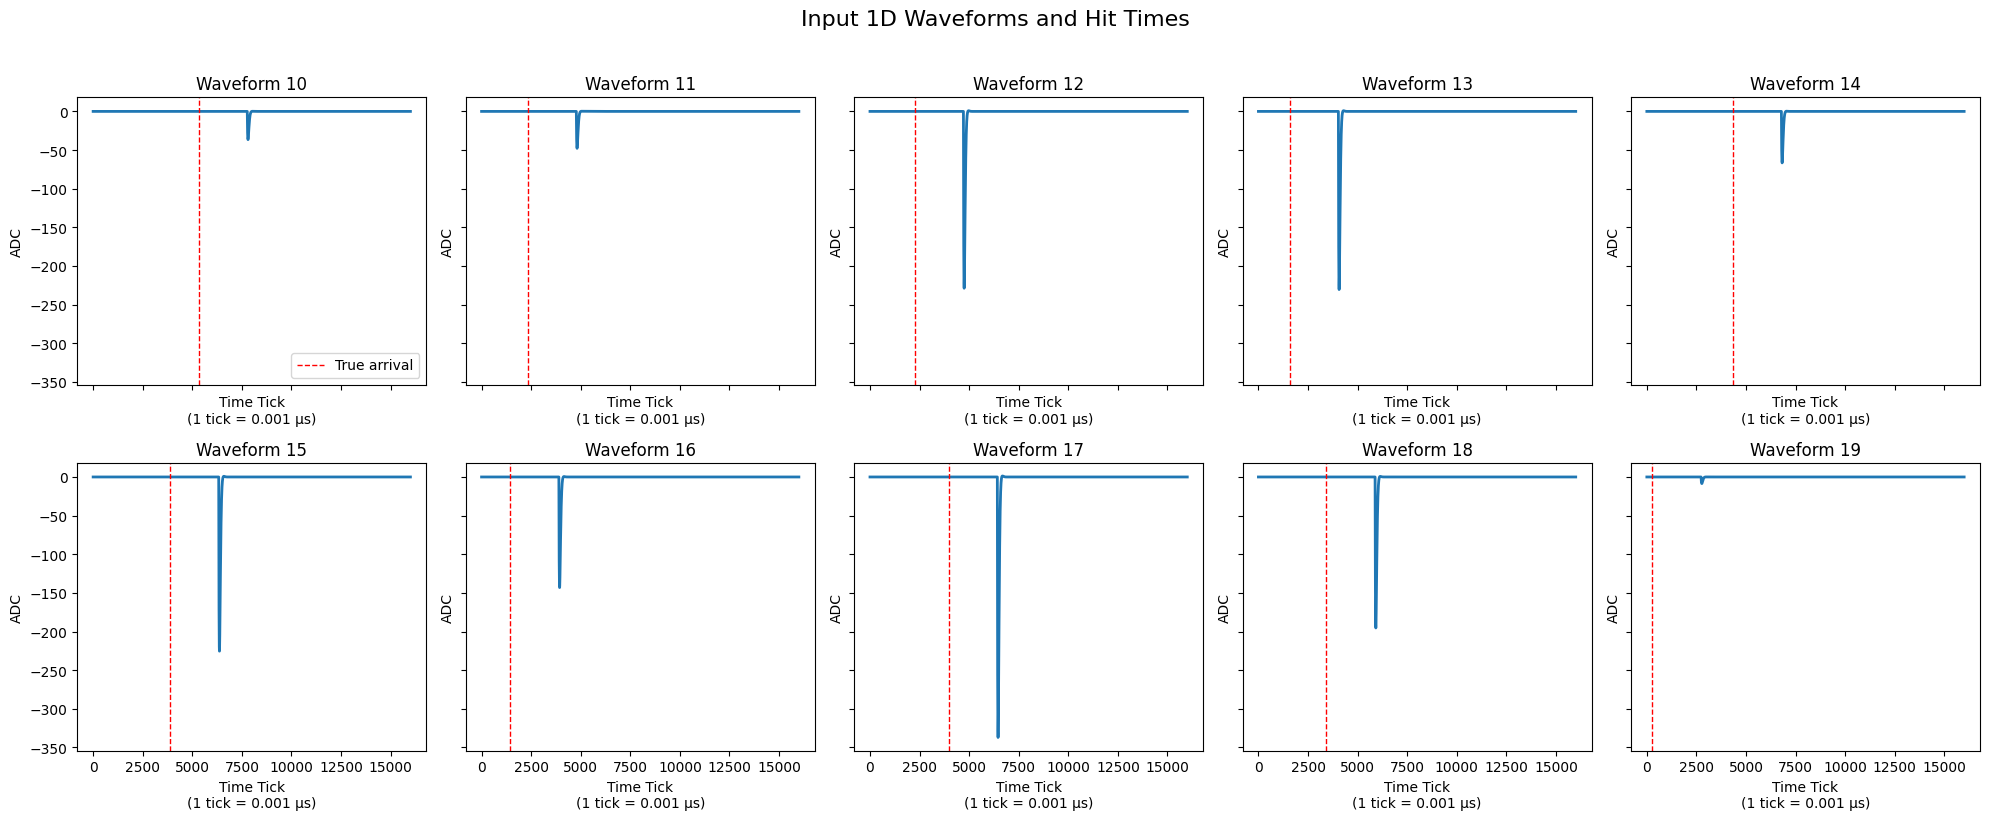

In [67]:
waveforms = np.load('10k_flashes.npy', allow_pickle=True).item()
ticks = np.arange(len(waveforms['waveforms'][0]))

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    wf_idx = i + 10  # because we're indexing waveforms[10:20]
    wf = waveforms['waveforms'][wf_idx]
    arrival = waveforms['arrival_times'][wf_idx] + (offset / sim.downsample_factor**1)

    ax.plot(ticks, wf, linewidth=2)
    ax.axvline(x=arrival, color='r', linestyle='--', linewidth=1, label='True arrival')
    ax.set_title(f"Waveform {wf_idx}")

    ax.set_xlabel(f"Time Tick\n(1 tick = {sim.light_tick_size * sim.downsample_factor} μs)")
    ax.set_ylabel("ADC")

# for ax in axes[6:10]:
#     ax.set_xticklabels([])

axes[0].legend()

plt.suptitle("Input 1D Waveforms and Hit Times", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()